In [ ]:
pip install rasterio


In [ ]:
!pip install scikit-image


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Import packages

In [ ]:
import os
import rasterio
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np
import spectral
from sklearn.model_selection import cross_val_score
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
import time
import gc


### **Visualization of Selected Bands from Hyperspectral TIFF Images**

TIFF files in 'dataset/aviris_hyperspectral_data':
19920612_AVIRIS_IndianPine_EW-line_R.tif
19920612_AVIRIS_IndianPine_NS-line.tif
19920612_AVIRIS_IndianPine_Site3.tif


/Users/lilia/Desktop/hyperspectral/myenv/lib/python3.12/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)



Visualizing: 19920612_AVIRIS_IndianPine_EW-line_R.tif
Shape of image: (220, 614, 1848)


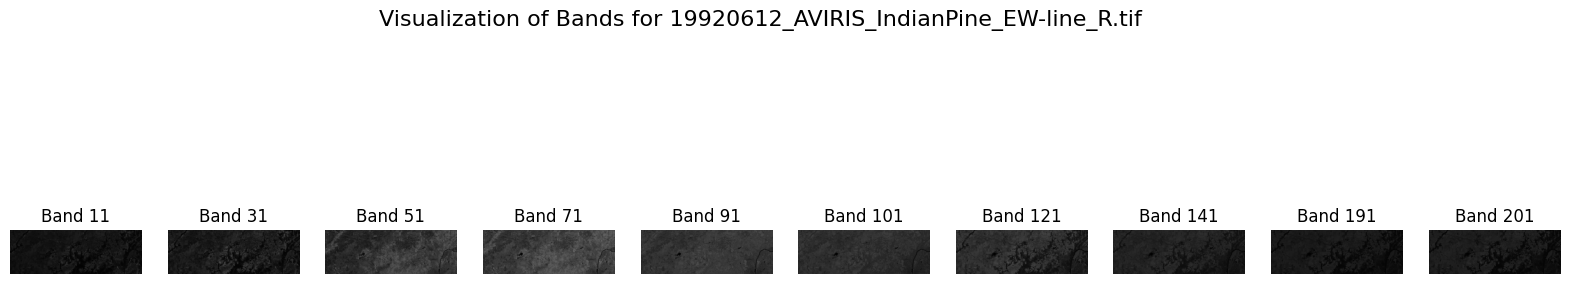


Visualizing: 19920612_AVIRIS_IndianPine_NS-line.tif
Shape of image: (220, 2678, 614)


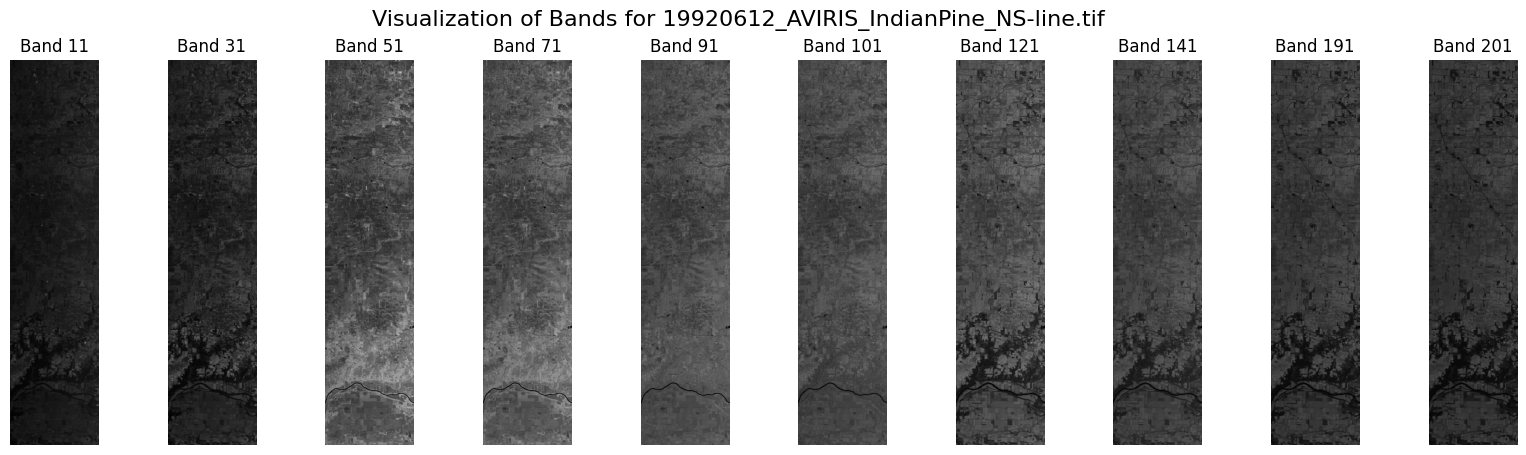


Visualizing: 19920612_AVIRIS_IndianPine_Site3.tif
Shape of image: (220, 145, 145)


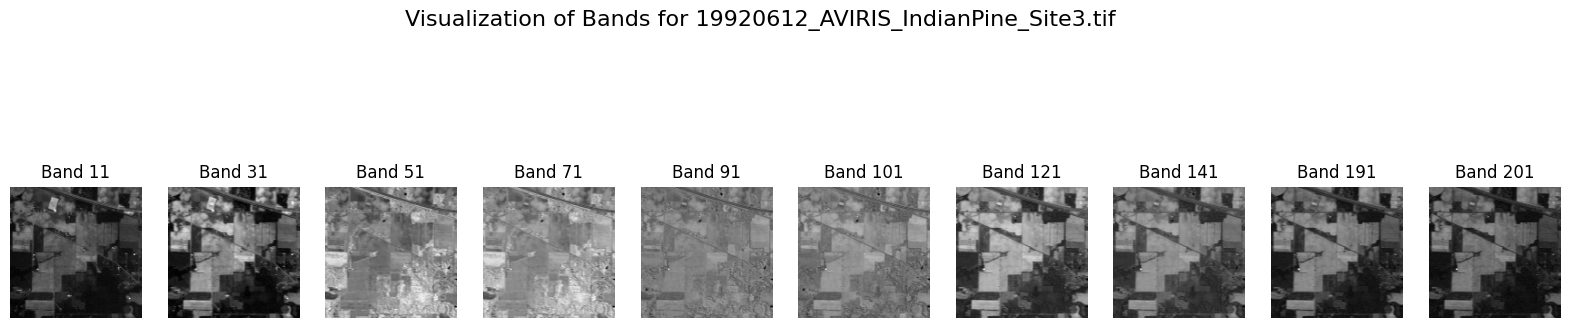

In [ ]:
# Path to the aviris_hyperspectral_data folder
hyperspectral_data_path = 'dataset/aviris_hyperspectral_data'

# List all files in the folder
files_in_hyperspectral_data = os.listdir(hyperspectral_data_path)

# Filter out only .tif files
tif_files = [f for f in files_in_hyperspectral_data if f.endswith('.tif')]

# Print the contents
print(f"TIFF files in '{hyperspectral_data_path}':")
for file in tif_files:
    print(file)

# Define the band indices you want to visualize
bands_to_visualize = [10, 30, 50, 70, 90, 100, 120, 140, 190, 200]

# Loop through each .tif file and visualize multiple bands
for tif_file in tif_files:
    file_path = os.path.join(hyperspectral_data_path, tif_file)

    with rasterio.open(file_path) as dataset:
        hyperspectral_image = dataset.read()
        print(f"\nVisualizing: {tif_file}")
        print(f"Shape of image: {hyperspectral_image.shape}")

        # Create a subplot to display all bands in a row
        fig, axes = plt.subplots(1, len(bands_to_visualize), figsize=(20, 5))

        # Loop through the specified bands
        for i, band_index in enumerate(bands_to_visualize):
            # Ensure the band index is within the range of the image
            if band_index < hyperspectral_image.shape[0]:
                # Rescale the current band for better visibility
                band_rescaled = (hyperspectral_image[band_index, :, :] - hyperspectral_image[band_index, :, :].min()) / (hyperspectral_image[band_index, :, :].max() - hyperspectral_image[band_index, :, :].min())

                # Plot the rescaled band on the subplot
                axes[i].imshow(band_rescaled, cmap='gray')
                axes[i].set_title(f"Band {band_index + 1}")
                axes[i].axis('off')  # Hide axes for a cleaner look
            else:
                print(f"Band {band_index + 1} is out of range for {tif_file}.")

        # Add an overall title for the image
        plt.suptitle(f"Visualization of Bands for {tif_file}", fontsize=16)
        plt.show()


19920612_AVIRIS_IndianPine_EW-line_R.tif:
Shape: (220, 614, 1848)
This image has 220 spectral bands, with spatial dimensions of 614 (height) x 1848 (width).
It is a wide image, capturing a significant area across multiple bands.

19920612_AVIRIS_IndianPine_NS-line.tif:
Shape: (220, 2678, 614)
This image also contains 220 spectral bands, but it has a taller structure with spatial dimensions of 2678 (height) x 614 (width).
The image is quite tall compared to its width, suggesting it covers a vertical area more extensively.

19920612_AVIRIS_IndianPine_Site3.tif:
Shape: (220, 145, 145)
This image is square-shaped, with 220 spectral bands and spatial dimensions of 145 (height) x 145 (width).
It is a much smaller image in terms of spatial coverage compared to the other two, possibly focusing on a more localized area.

Summary of Shapes:
The first image (EW-line_R) is wide and captures a horizontal area, making it ideal for scenes where the width is more significant.

The second image (NS-line) is tall and captures a vertical area, which could be useful for applications where the height of the scene is more important.

The third image (Site3) is square and smaller in spatial size, likely focusing on a localized, detailed region.

### **Normalization of Hyperspectral TIFF Images**

In [ ]:
def normalize_image(image):
    # Rescale each band to the range 0-1
    return (image - image.min()) / (image.max() - image.min())

normalized_images = {}
for tif_file in tif_files:
    file_path = os.path.join(hyperspectral_data_path, tif_file)
    with rasterio.open(file_path) as dataset:
        hyperspectral_image = dataset.read()  # Read all bands
        normalized_images[tif_file] = normalize_image(hyperspectral_image)
        print(f"{tif_file} has been normalized.")


19920612_AVIRIS_IndianPine_EW-line_R.tif has been normalized.
19920612_AVIRIS_IndianPine_NS-line.tif has been normalized.
19920612_AVIRIS_IndianPine_Site3.tif has been normalized.


### **Principal Component Analysis (PCA) Explained Variance for Hyperspectral Images**

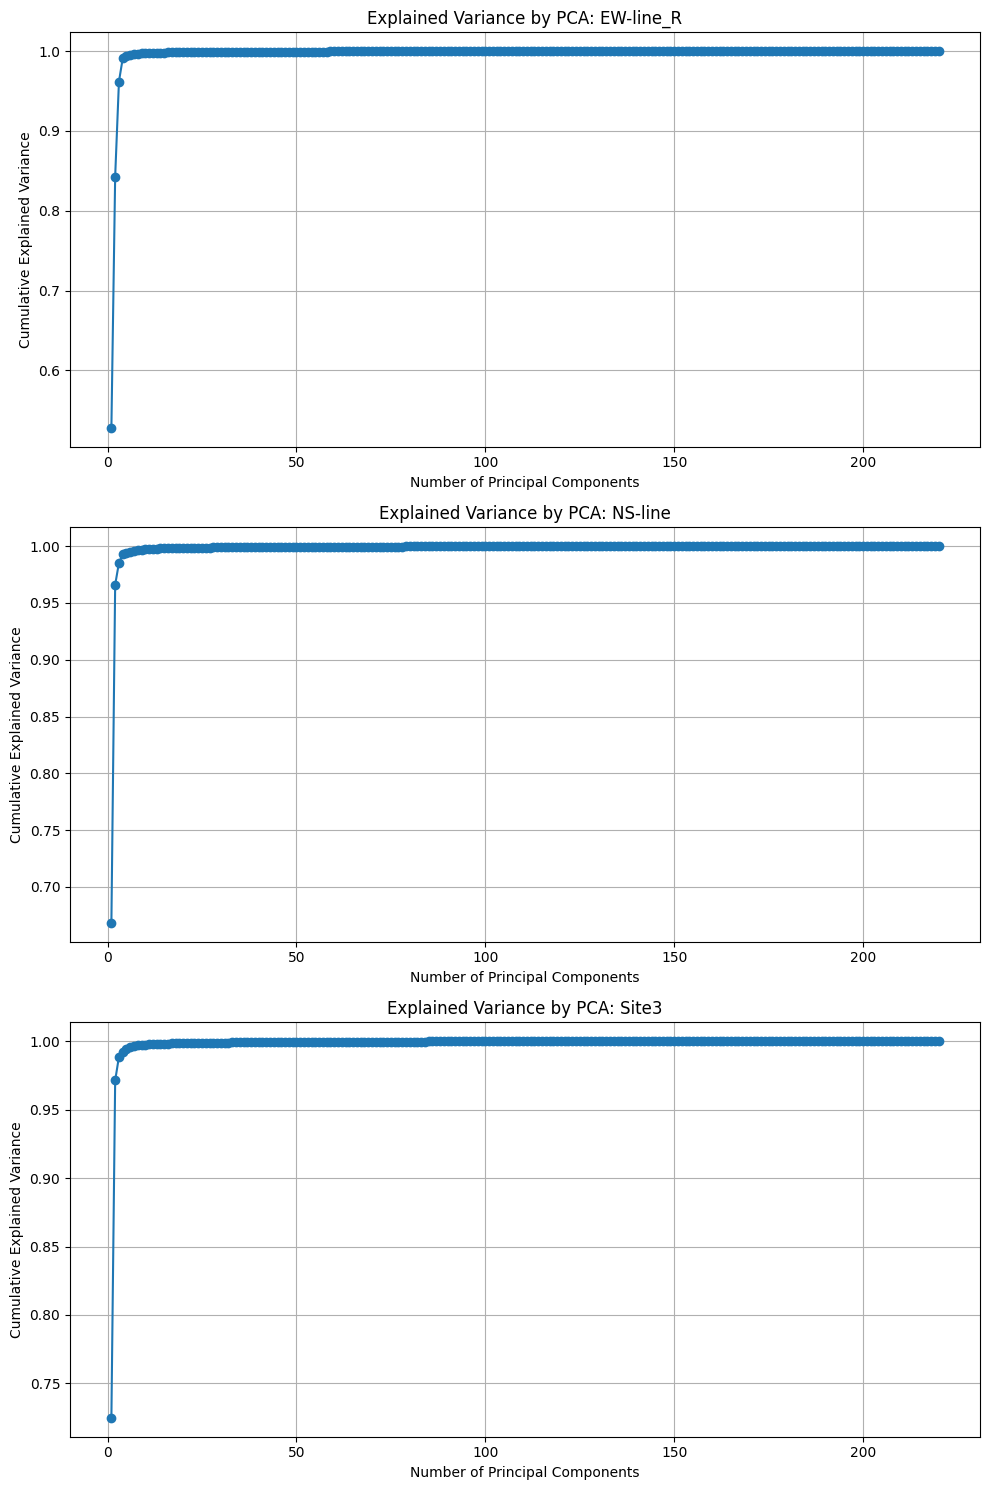

In [ ]:
from sklearn.decomposition import PCA
def plot_pca_variance(image, ax, title):
    h, w, bands = image.shape[1], image.shape[2], image.shape[0]
    reshaped_image = image.reshape(bands, h * w).T  # Reshape to (pixels, bands)

    # Apply PCA without reducing components yet
    pca = PCA(n_components=bands)
    pca.fit(reshaped_image)

    # Plot the explained variance ratio
    ax.plot(range(1, bands + 1), pca.explained_variance_ratio_.cumsum(), marker='o')
    ax.set_xlabel('Number of Principal Components')
    ax.set_ylabel('Cumulative Explained Variance')
    ax.set_title(title)
    ax.grid(True)

# Create a figure with 3 rows for the 3 images
fig, axes = plt.subplots(3, 1, figsize=(10, 15))

# Plot PCA variance for each image
plot_pca_variance(normalized_images['19920612_AVIRIS_IndianPine_EW-line_R.tif'], axes[0], 'Explained Variance by PCA: EW-line_R')
plot_pca_variance(normalized_images['19920612_AVIRIS_IndianPine_NS-line.tif'], axes[1], 'Explained Variance by PCA: NS-line')
plot_pca_variance(normalized_images['19920612_AVIRIS_IndianPine_Site3.tif'], axes[2], 'Explained Variance by PCA: Site3')

# Adjust the layout to avoid overlapping
plt.tight_layout()
plt.show()


The plots for each image show that:

EW-line_R: The first few principal components capture almost all the variance, with around 95% variance captured by less than 10 components.
NS-line: Similarly, this image also shows that 95% of the variance is explained by around 10-15 components.

Site3: The cumulative variance for this image follows the same pattern, with 95% of the variance captured by fewer than 10 components.

Across all three images, a small number of principal components (around 10-20) explain most of the variance.
 This indicates that PCA can be used to reduce the number of bands significantly while retaining almost all the information.

### **Dimensionality Reduction of Hyperspectral Images using PCA**

In [ ]:
def apply_pca(image, num_components=10):
    h, w, bands = image.shape[1], image.shape[2], image.shape[0]
    reshaped_image = image.reshape(bands, h * w).T  # Reshape to (pixels, bands)

    # Apply PCA with the specified number of components
    pca = PCA(n_components=num_components)
    pca_transformed = pca.fit_transform(reshaped_image)

    # Reshape back to the original image size but with reduced bands
    pca_image = pca_transformed.T.reshape(num_components, h, w)

    return pca_image, pca
# Dictionary to store PCA models along with images
pca_images = {}
pca_models = {}  # New dictionary to store the PCA models

# Apply PCA to all images with 10 components
for tif_file, image in normalized_images.items():
    pca_image, pca_model = apply_pca(image, num_components=10)

    # Store the PCA-transformed image
    pca_images[tif_file] = pca_image

    # Store the PCA model for later access
    pca_models[tif_file] = pca_model

    print(f"PCA applied to {tif_file} with shape: {pca_image.shape}")


PCA applied to 19920612_AVIRIS_IndianPine_EW-line_R.tif with shape: (10, 614, 1848)
PCA applied to 19920612_AVIRIS_IndianPine_NS-line.tif with shape: (10, 2678, 614)
PCA applied to 19920612_AVIRIS_IndianPine_Site3.tif with shape: (10, 145, 145)


In [ ]:
# Loop through all PCA models and print the components (eigenvectors)
for tif_file, pca_model in pca_models.items():
    print(f"PCA Components (Eigenvectors) for {tif_file}:")
    print(pca_model.components_)


PCA Components (Eigenvectors) for 19920612_AVIRIS_IndianPine_EW-line_R.tif:
[[-1.61932777e-02 -9.47965107e-03 -1.12005873e-02 ... -9.38804943e-04
  -3.73296475e-04 -3.82430246e-04]
 [ 6.21617009e-02  4.18635462e-02  5.20161839e-02 ...  1.72775158e-03
   6.95100783e-04  6.78575451e-04]
 [ 9.95729792e-01 -1.15865546e-02 -2.13077508e-03 ...  3.20559312e-04
   1.96203328e-04 -2.37168055e-05]
 ...
 [ 4.66002308e-03  7.18869348e-01  3.46905755e-01 ...  4.62760449e-03
   3.45648470e-03  3.47478184e-03]
 [ 1.43432240e-02  4.34261656e-01  4.87703549e-02 ... -8.28577416e-03
  -3.68759566e-03 -4.38458150e-03]
 [-2.77274763e-03 -4.26430218e-01  8.62974194e-01 ... -1.44467046e-03
  -4.61922844e-04 -1.19750681e-03]]
PCA Components (Eigenvectors) for 19920612_AVIRIS_IndianPine_NS-line.tif:
[[ 1.62221156e-02  2.00151929e-02  2.38927443e-02 ... -2.49529470e-04
  -1.13626603e-04 -1.21689873e-04]
 [ 3.29316239e-02  4.79932249e-02  5.83052366e-02 ...  2.25168512e-03
   8.68035008e-04  8.73187412e-04]
 [-5


nir_component = 2 (Component 3 in the list)

red_component = 1 (Component 2 in the list)

blue_component = 0 (Component 1 in the list)

swir_component = 3 (Component 4 in the list)

### **NDVI Calculation and Visualization from PCA Components**

In [ ]:
# Assume we have identified the NIR and Red components from PCA as indices 1 and 2
nir_component = 1
red_component = 2

# Function to calculate NDVI
def calculate_ndvi(pca_image, nir_index, red_index):
    # Extract the NIR and Red bands
    nir_band = pca_image[nir_index, :, :]
    red_band = pca_image[red_index, :, :]

    # NDVI formula
    ndvi = (nir_band - red_band) / (nir_band + red_band + 1e-10)  # Avoid division by zero

    # Clip the NDVI values to ensure they fall within the range [-1, 1]
    ndvi = np.clip(ndvi, -1, 1)

    return ndvi

# Function to plot NDVI
def plot_ndvi(ndvi_image, tif_file):
    plt.figure(figsize=(6, 6))
    plt.imshow(ndvi_image, cmap='RdYlGn', vmin=-1, vmax=1)  # Set NDVI range to [-1, 1]
    plt.colorbar(label='NDVI')
    plt.title(f'NDVI for {tif_file}')
    plt.axis('off')
    plt.show()

# Function to plot NDVI histograms
def plot_ndvi_histogram(ndvi_image, tif_file):
    plt.figure(figsize=(6, 4))
    plt.hist(ndvi_image.ravel(), bins=100, range=(-1, 1), color='green', alpha=0.7)
    plt.xlabel('NDVI Value')
    plt.ylabel('Frequency')
    plt.title(f'NDVI Histogram for {tif_file}')
    plt.show()



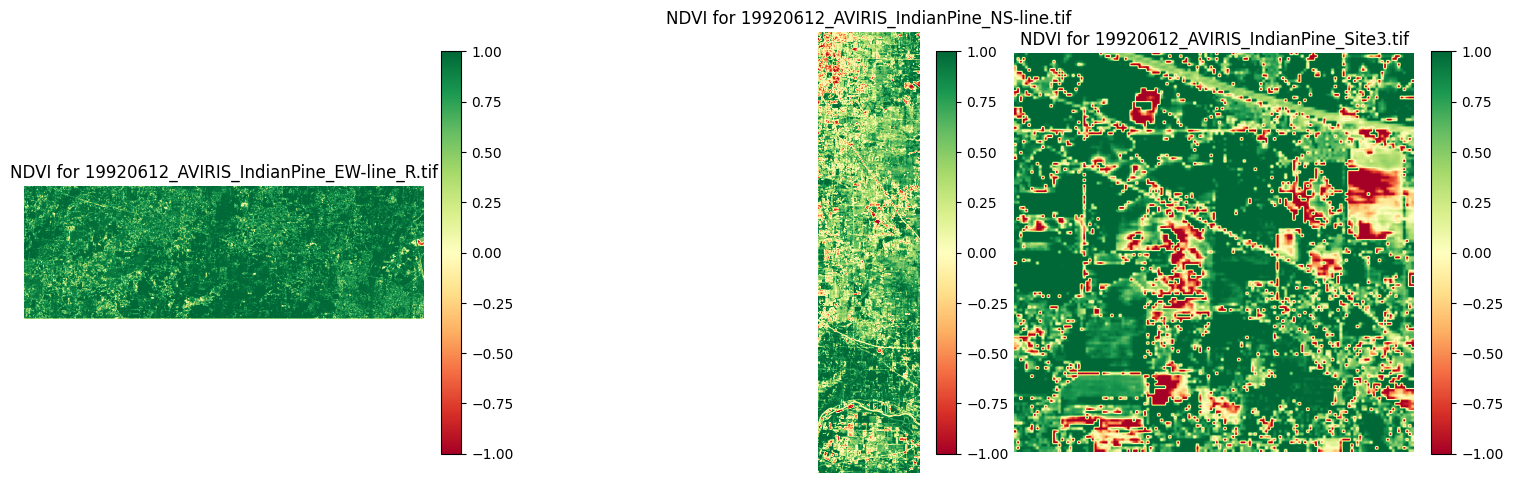

In [ ]:
# Number of images to display
num_images = len(pca_images)

# Create subplots with 1 row and as many columns as there are images
fig, axes = plt.subplots(1, num_images, figsize=(15, 5))

# Adjust the layout to prevent overlap
fig.tight_layout()

# Calculate and plot NDVI for each PCA-reduced image in one row
for i, (tif_file, pca_image) in enumerate(pca_images.items()):
    ndvi_image = calculate_ndvi(pca_image, nir_component, red_component)

    # Plot NDVI map in the i-th subplot
    ax = axes[i]
    ax.imshow(ndvi_image, cmap='RdYlGn')
    ax.set_title(f'NDVI for {tif_file}')
    ax.axis('off')
    plt.colorbar(ax.imshow(ndvi_image, cmap='RdYlGn'), ax=ax, fraction=0.046, pad=0.04)

# Display the plot
plt.show()


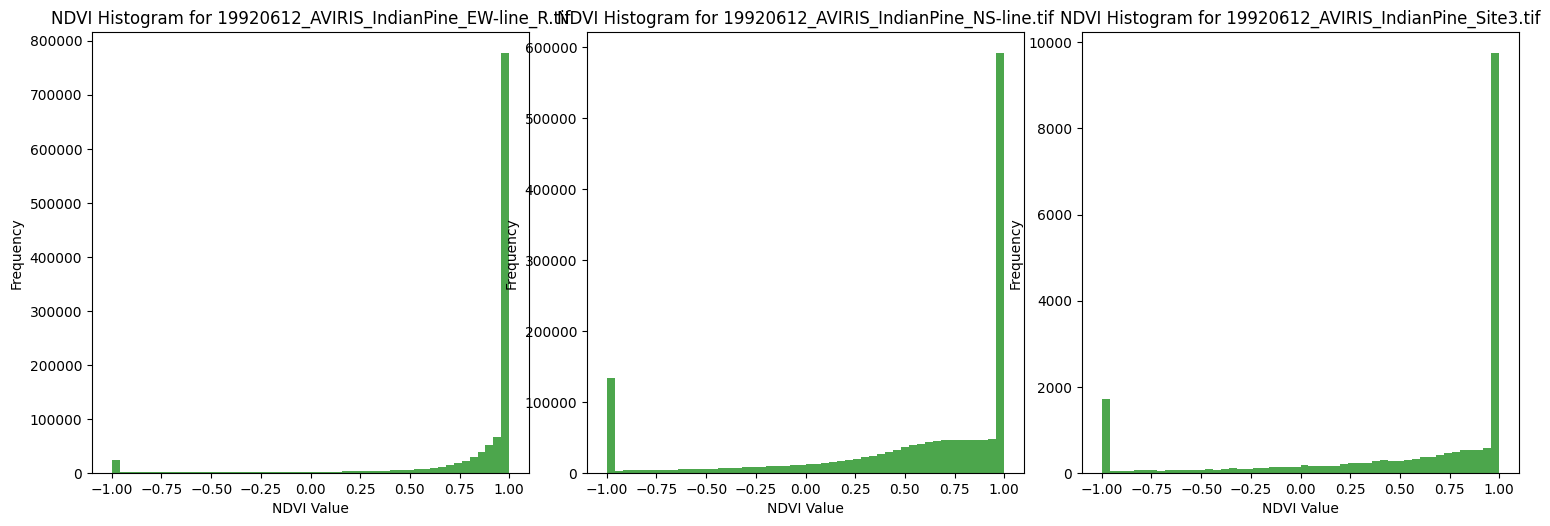

In [ ]:
# Number of images to display
num_images = len(pca_images)

# Create subplots with 1 row and as many columns as there are images
fig, axes = plt.subplots(1, num_images, figsize=(15, 5))

# Adjust the layout to prevent overlap
fig.tight_layout()

# Calculate and plot NDVI histograms for each PCA-reduced image in one row
for i, (tif_file, pca_image) in enumerate(pca_images.items()):
    ndvi_image = calculate_ndvi(pca_image, nir_component, red_component)

    # Plot NDVI histogram in the i-th subplot
    ax = axes[i]
    ax.hist(ndvi_image.ravel(), bins=50, color='green', alpha=0.7)
    ax.set_title(f'NDVI Histogram for {tif_file}')
    ax.set_xlabel('NDVI Value')
    ax.set_ylabel('Frequency')

# Display the plot
plt.show()



The histograms for all three images show a common pattern where the majority of NDVI values are positive, indicating the dominance of vegetation in the scenes.

The third dataset shows more variability in NDVI values, suggesting a more heterogeneous landscape with mixed land cover.

The sharp peaks in the histograms for the first two datasets suggest dense vegetation cover, whereas the third dataset's histogram indicates more diversity in land cover, with a broader range of NDVI values.

### **Calculation and Visualization of Spectral Indices (EVI, SAVI, NDWI)**

In [ ]:
# Function to calculate EVI
def calculate_evi(nir_band, red_band, blue_band, g=2.5, L=1, C1=6, C2=7.5):
    evi = g * (nir_band - red_band) / (nir_band + C1 * red_band - C2 * blue_band + L)
    return np.clip(evi, -1, 1)

# Function to calculate SAVI
def calculate_savi(nir_band, red_band, L=0.5):
    savi = (nir_band - red_band) / (nir_band + red_band + L)
    return np.clip(savi, -1, 1)

# Function to calculate NDWI
def calculate_ndwi(nir_band, swir_band):
    ndwi = (nir_band - swir_band) / (nir_band + swir_band + 1e-10)  # Avoid division by zero
    return np.clip(ndwi, -1, 1)

# Function to visualize the spectral indices
def plot_index(index_image, title):
    plt.figure(figsize=(6, 6))
    plt.imshow(index_image, cmap='RdYlGn')  # 'RdYlGn' is good for vegetation indices
    plt.colorbar(label=title)
    plt.title(title)
    plt.axis('off')
    plt.show()


### **Visualization of Spectral Indices (EVI, SAVI, NDWI) for PCA-Transformed Hyperspectral Images**



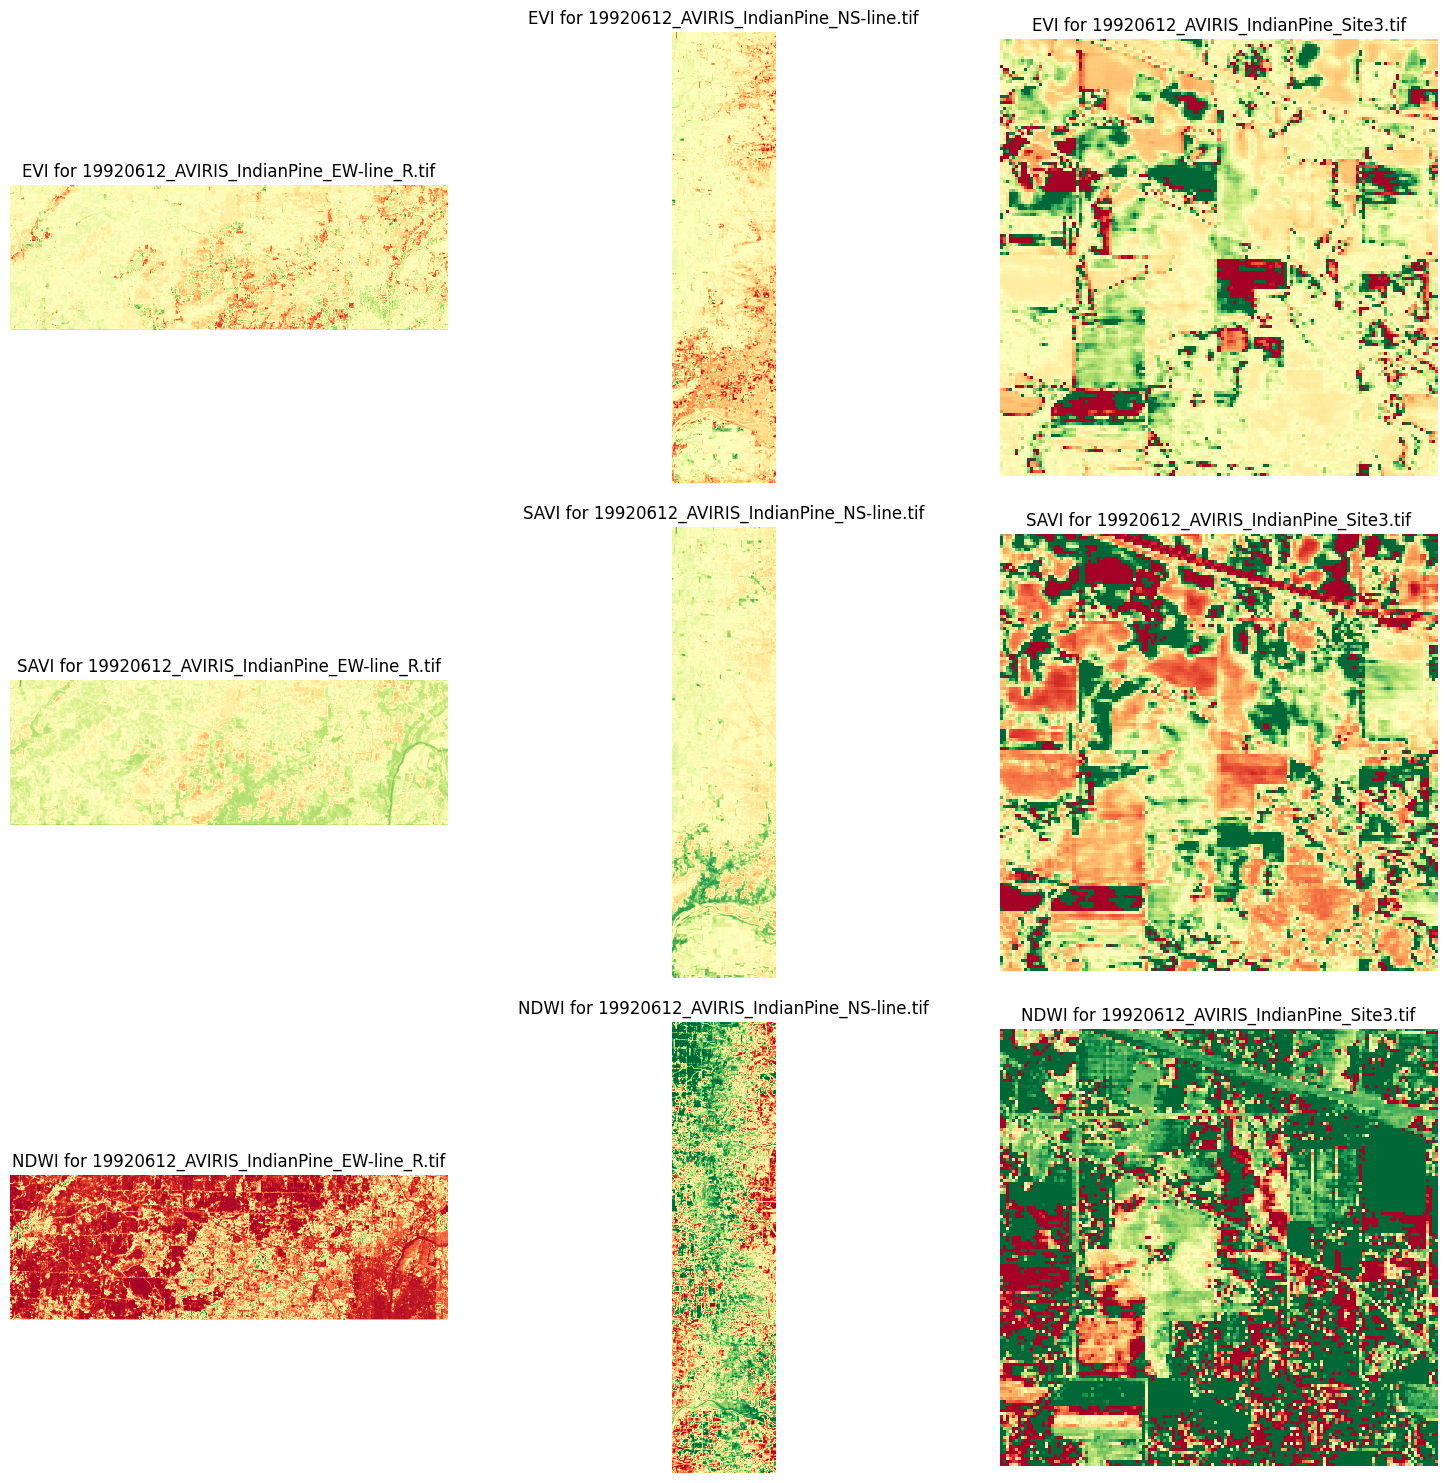

In [ ]:
# Number of images to display (assumed to be number of PCA images)
num_images = len(pca_images)

# Create subplots with 3 rows (for EVI, SAVI, NDWI) and num_images columns
fig, axes = plt.subplots(3, num_images, figsize=(15, 15))

# Adjust the layout to prevent overlap
fig.tight_layout()

# Assign PCA components (from previous analysis)
nir_component = 2
red_component = 1
blue_component = 0
swir_component = 3

# Loop through each image and plot EVI, SAVI, and NDWI for each
for i, (tif_file, pca_image) in enumerate(pca_images.items()):
    nir_band = pca_image[nir_component, :, :]
    red_band = pca_image[red_component, :, :]
    blue_band = pca_image[blue_component, :, :]
    swir_band = pca_image[swir_component, :, :]

    # Calculate EVI, SAVI, and NDWI
    evi_image = calculate_evi(nir_band, red_band, blue_band)
    savi_image = calculate_savi(nir_band, red_band)
    ndwi_image = calculate_ndwi(nir_band, swir_band)

    # Plot EVI in the first row
    axes[0, i].imshow(evi_image, cmap='RdYlGn')
    axes[0, i].set_title(f'EVI for {tif_file}')
    axes[0, i].axis('off')

    # Plot SAVI in the second row
    axes[1, i].imshow(savi_image, cmap='RdYlGn')
    axes[1, i].set_title(f'SAVI for {tif_file}')
    axes[1, i].axis('off')

    # Plot NDWI in the third row
    axes[2, i].imshow(ndwi_image, cmap='RdYlGn')
    axes[2, i].set_title(f'NDWI for {tif_file}')
    axes[2, i].axis('off')

# Display the plot
plt.show()


**Enhanced Vegetation Index (EVI):**
19920612_AVIRIS_IndianPine_EW-line_R.tif: EVI values are mostly low with some areas of higher vegetation activity. This suggests that the majority of the area has sparse vegetation with some regions showing higher biomass.
19920612_AVIRIS_IndianPine_NS-line.tif: The vertical slice shows varied vegetation density, with more visible green areas indicating regions with higher photosynthetic activity.

19920612_AVIRIS_IndianPine_Site3.tif: This image shows a wider range of vegetation intensities, with clear areas of high and low biomass, reflecting different land covers or crop types.

**Soil Adjusted Vegetation Index (SAVI):**
19920612_AVIRIS_IndianPine_EW-line_R.tif: SAVI shows a more uniform distribution across the region, indicating areas where vegetation cover may be sparse but still present.

19920612_AVIRIS_IndianPine_NS-line.tif: The vertical slice highlights the influence of soil in areas with lower vegetation. SAVI seems to better capture vegetation in these regions compared to EVI.

19920612_AVIRIS_IndianPine_Site3.tif: SAVI reveals more detail in regions where soil is more exposed, providing better contrast for regions with sparse vegetation compared to EVI.

**Normalized Difference Water Index (NDWI):**
19920612_AVIRIS_IndianPine_EW-line_R.tif: NDWI is mostly negative or low, indicating very little water content. The red shades confirm that most of the area is dry land or vegetation with low moisture.

19920612_AVIRIS_IndianPine_NS-line.tif: Similar patterns of low NDWI, suggesting minimal water presence across the entire vertical slice.

19920612_AVIRIS_IndianPine_Site3.tif: NDWI highlights regions with possible higher moisture content, but overall it shows a dry landscape, with areas of possible agricultural or vegetated land.

### **Loading and Displaying Dimensions of Hyperspectral and Ground Truth Images**

In [ ]:
# Function to load an image and return its dimensions
def load_image_dimensions(image_file):
    with rasterio.open(image_file) as src:
        return src.width, src.height

# Path to the folders containing hyperspectral and ground truth images
hyperspectral_folder = 'dataset/aviris_hyperspectral_data'
ground_truth_folder = 'dataset/ground_reference_photos'

# Load and print dimensions of all hyperspectral images in the folder
print("Hyperspectral Images:")
for filename in os.listdir(hyperspectral_folder):
    if filename.endswith(".tif"):
        file_path = os.path.join(hyperspectral_folder, filename)
        width, height = load_image_dimensions(file_path)
        print(f'Hyperspectral image {filename}: Width = {width}, Height = {height}')

# Load and print dimensions of all ground truth images in the folder
print("\nGround Truth Images:")
for filename in os.listdir(ground_truth_folder):
    if filename.endswith(".tif"):
        file_path = os.path.join(ground_truth_folder, filename)
        width, height = load_image_dimensions(file_path)
        print(f'Ground truth image {filename}: Width = {width}, Height = {height}')


Hyperspectral Images:
Hyperspectral image 19920612_AVIRIS_IndianPine_EW-line_R.tif: Width = 1848, Height = 614
Hyperspectral image 19920612_AVIRIS_IndianPine_NS-line.tif: Width = 614, Height = 2678
Hyperspectral image 19920612_AVIRIS_IndianPine_Site3.tif: Width = 145, Height = 145

Ground Truth Images:
Ground truth image field_3-17a.tif: Width = 2106, Height = 1333
Ground truth image field_3-40a.tif: Width = 2122, Height = 1365
Ground truth image field_3-21b.tif: Width = 2117, Height = 1285
Ground truth image field_3-17b.tif: Width = 2143, Height = 1285
Ground truth image field_3-21a.tif: Width = 2122, Height = 1285
Ground truth image field_3-17c.tif: Width = 2021, Height = 1344
Ground truth image field_3-20a.tif: Width = 2117, Height = 1338
Ground truth image field_3-17d.tif: Width = 2021, Height = 1285
Ground truth image field_3-20b.tif: Width = 2021, Height = 1285
Ground truth image field_3-20c.tif: Width = 2021, Height = 1285
Ground truth image field_3-11b.tif: Width = 2122, Height

### **Class Mapping for Ground Truth Pixel Values in Hyperspectral Image Classification**

In [ ]:
# Define the class mapping based on the pixel values in the ground truth
class_mapping = {
    0: 'Background',
    1: 'Corn',
    2: 'Corn-notill',
    3: 'Corn-mintill',
    4: 'Grass/Pasture',
    5: 'Grass/Trees',
    6: 'Hay-windrowed',
    7: 'Soybeans-notill',
    8: 'Soybeans-mintill',
    9: 'Soybeans-clean',
    10: 'Wheat',
    11: 'Woods',
    12: 'Bldg-Grass-Tree-Drives',
    13: 'Stone-steel towers',
    14: 'Alfalfa',
    15: 'Oats',
    255: 'Unknown'
}


In [ ]:
def map_labels(ground_truth_image, class_mapping, default_class='Unknown'):
    """
    Map the pixel values in the ground truth image to corresponding class labels.

    Args:
    ground_truth_image: numpy array (original ground truth with pixel values)
    class_mapping: dictionary mapping pixel values to class names
    default_class: label to use for undefined pixel values

    Returns:
    mapped_labels: numpy array of shape [height, width] with class names as labels
    """
    mapped_labels = np.full(ground_truth_image.shape, default_class)
    for pixel_value, class_name in class_mapping.items():
        mapped_labels[ground_truth_image == pixel_value] = class_name
    return mapped_labels


### **Resizing Ground Truth Labels to Match Hyperspectral Image Dimensions**

In [ ]:
# Resize ground truth before mapping labels
def resize_ground_truth(ground_truth_image, target_shape):
    """
    Resize the ground truth image to match the target shape.

    Args:
    ground_truth_image: numpy array of shape [height, width]
    target_shape: tuple (height, width) of the hyperspectral image

    Returns:
    resized_ground_truth: resized ground truth to match the hyperspectral image size
    """
    resized_gt = resize(ground_truth_image, target_shape, preserve_range=True)
    return resized_gt.astype(int)  # Ensure the values remain integers


### **Mapping Resized Ground Truth Pixel Values to Class Labels**

In [ ]:
# Map the pixel values after resizing
resized_ground_truth = resize_ground_truth(ground_truth_image, (hyperspectral_image.shape[1], hyperspectral_image.shape[2]))

# Now map the resized ground truth values to the appropriate class labels
mapped_ground_truth = map_labels(resized_ground_truth, class_mapping)


### **Encoding Ground Truth Labels with LabelEncoder**

In [ ]:
from sklearn.preprocessing import LabelEncoder

def encode_labels(y_labels):
    """
    Convert the ground truth labels to integer classes using LabelEncoder.

    Args:
    y_labels: numpy array of shape [pixels] (ground truth labels)

    Returns:
    encoded_labels: numpy array of shape [pixels] (encoded integer labels)
    """
    label_encoder = LabelEncoder()
    encoded_labels = label_encoder.fit_transform(y_labels)
    return encoded_labels


### **Calculation and Integration of Spectral Indices (NDVI, EVI, SAVI, NDWI) into Hyperspectral Image Patches**

In [ ]:
# Calcul des indices NDVI, EVI, SAVI, et NDWI à partir des bandes hyperspectrales
ndvi, evi, savi, ndwi = calculate_indices(hyperspectral_image)

# Aplatir les indices pour qu'ils aient la même forme que les patches
ndvi_flattened = ndvi.flatten()
evi_flattened = evi.flatten()
savi_flattened = savi.flatten()
ndwi_flattened = ndwi.flatten()

# Ajouter les indices aplatis à X_patches
X_patches_with_indices = np.hstack([X_patches, ndvi_flattened[:, np.newaxis], evi_flattened[:, np.newaxis],
                                    savi_flattened[:, np.newaxis], ndwi_flattened[:, np.newaxis]])

# Vérifiez la forme des données après ajout des indices
print(f"Forme finale de X_patches_with_indices: {X_patches_with_indices.shape}")


Forme finale de X_patches_with_indices: (21025, 224)


### **Hyperspectral Image Classification with Random Forest and Spectral Indices**



In [ ]:
# Flatten the ground truth labels to match the shape of X_patches
# Ensure the number of labels matches the number of patches
y_labels_resized = y_labels[:X_patches.shape[0]]  # Reshape or trim ground truth to match hyperspectral patches

# Check the shape of the labels before encoding
print(f"Shape of y_labels before encoding: {y_labels_resized.shape}")

# Function to encode the labels to integer classes
def encode_labels(y_labels):
    label_encoder = LabelEncoder()
    encoded_labels = label_encoder.fit_transform(y_labels)
    return encoded_labels

# Encode the ground truth labels
y_encoded = encode_labels(y_labels_resized)

# Check the shape of the encoded labels
print(f"Shape of y_encoded after encoding: {y_encoded.shape}")

# Combine NDVI, EVI, SAVI, and NDWI with X_patches
X_patches_with_indices = np.hstack([X_patches, ndvi[:, np.newaxis], evi[:, np.newaxis],
                                    savi[:, np.newaxis], ndwi[:, np.newaxis]])

# Check the shape of X_patches_with_indices
print(f"X_patches_with_indices shape: {X_patches_with_indices.shape}")

# Split the dataset into training and validation sets (80% training, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(X_patches_with_indices, y_encoded, test_size=0.2, random_state=42)

print(f"Training Data Shape: {X_train.shape}")
print(f"Validation Data Shape: {X_val.shape}")
print(f"Training Labels Shape: {y_train.shape}")
print(f"Validation Labels Shape: {y_val.shape}")

# Initialize the classifier
classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Start timing the training process
start_time = time.time()

# Train the classifier on the training data
classifier.fit(X_train, y_train)

# Calculate the time taken for training
training_time = time.time() - start_time
print(f"Training completed in {training_time:.2f} seconds")

# Evaluate the classifier on the validation data
accuracy = classifier.score(X_val, y_val)
print(f"Validation Accuracy: {accuracy * 100:.2f}%")


Shape of y_labels before encoding: (21025,)
Shape of y_encoded after encoding: (21025,)
X_patches_with_indices shape: (21025, 224)
Training Data Shape: (16820, 224)
Validation Data Shape: (4205, 224)
Training Labels Shape: (16820,)
Validation Labels Shape: (4205,)
Training completed in 0.23 seconds
Validation Accuracy: 100.00%


### **5-Fold Cross-Validation for Hyperspectral Image Classification with Random Forest**

In [ ]:
# Perform 5-fold cross-validation
cross_val_scores = cross_val_score(classifier, X_patches_with_indices, y_encoded, cv=5)

print(f"Cross-validation accuracy scores: {cross_val_scores}")
print(f"Mean cross-validation accuracy: {np.mean(cross_val_scores) * 100:.2f}%")


Cross-validation accuracy scores: [1. 1. 1. 1. 1.]
Mean cross-validation accuracy: 100.00%
